## CFPB Complaint Analysis

In [1]:
# Importing Libraries

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
from sklearn.metrics import ConfusionMatrixDisplay
import xgboost as xgb
from sklearn.metrics import confusion_matrix
import numpy as np

# Load the dataset
complaints = pd.read_csv("/Users/priyakundu/Documents/NYU/Sem 3/BA/Homeworks/Datasets/complaints_25Nov21.csv")
complaints

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2016-10-26,Money transfers,International money transfer,Other transaction issues,NaN,"To whom it concerns, I would like to file a fo...",Company has responded to the consumer and the ...,"CITIBANK, N.A.",NaN,NaN,NaN,Consent provided,Web,2016-10-29,Closed with explanation,Yes,No,2180490
1,2015-03-27,Bank account or service,Other bank product/service,"Account opening, closing, or management",NaN,My name is XXXX XXXX XXXX and huband name is X...,Company chooses not to provide a public response,"CITIBANK, N.A.",PA,151XX,Older American,Consent provided,Web,2015-03-27,Closed with explanation,Yes,No,1305453
2,2015-04-20,Bank account or service,Other bank product/service,"Making/receiving payments, sending money",NaN,XXXX 2015 : I called to make a payment on XXXX...,Company chooses not to provide a public response,U.S. BANCORP,PA,152XX,NaN,Consent provided,Web,2015-04-22,Closed with monetary relief,Yes,No,1337613
3,2013-04-29,Mortgage,Conventional fixed mortgage,"Application, originator, mortgage broker",NaN,NaN,NaN,JPMORGAN CHASE & CO.,VA,22406,Servicemember,NaN,Phone,2013-04-30,Closed with explanation,Yes,Yes,393900
4,2013-05-29,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",GA,30044,NaN,NaN,Referral,2013-05-31,Closed with explanation,Yes,No,418647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207255,2015-05-24,Debt collection,Credit card,Taking/threatening an illegal action,Sued w/o proper notification of suit,NaN,NaN,JPMORGAN CHASE & CO.,FL,33133,NaN,Consent not provided,Web,2015-05-24,Closed with explanation,Yes,No,1390395
207256,2012-01-10,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,JPMORGAN CHASE & CO.,NY,10312,NaN,NaN,Referral,2012-01-11,Closed without relief,Yes,Yes,12192
207257,2012-07-17,Student loan,Non-federal student loan,Repaying your loan,NaN,NaN,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",NH,032XX,NaN,NaN,Web,2012-07-18,Closed with explanation,Yes,No,118351
207258,2016-09-29,Bank account or service,Checking account,"Account opening, closing, or management",NaN,Near the end of XXXX 2016 I opened a Citigold ...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",CA,900XX,NaN,Consent provided,Web,2016-09-29,Closed with non-monetary relief,Yes,No,2138969


### Question 1 

##### Our first step would be to check how many customers have raised disputes after the bank has guven their first resolution

In [2]:
# Set your X (predictor) and y (predicted) variables
selected_features = ['Product', 'Sub-product', 'Issue', 'State', 'Tags', 'Submitted via',
                     'Company response to consumer', 'Timely response?']
X = complaints[selected_features]
X.fillna('unknown', inplace = True)
le = LabelEncoder()
y = le.fit_transform(complaints['Consumer disputed?'])

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, columns=selected_features)

# Split the data into a test and train set (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=123)

# Calculate the proportion of consumers who raised a dispute in the test set
proportion_disputed_test = sum(y_test) / len(y_test)
print("Proportion of consumers who raised a dispute in the test set: {:.2f}%".format(proportion_disputed_test * 100))

/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_42340/1625587382.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna('unknown', inplace = True)


Proportion of consumers who raised a dispute in the test set: 21.59%


### Question 2

##### We have randomly undersampled the train set to check how many customers have raised distputes

In [3]:
# Perform random undersampling
if proportion_disputed_test < 0.3:
    undersampler = RandomUnderSampler(random_state=123)
    X_train, y_train = undersampler.fit_resample(X_encoded, y)

# Check the proportion of disputed complaints in the training dataset after random undersampling
proportion_disputed_after_undersampling = (y_train == 1).mean()

print(f"The proportion of consumers who raised a dispute in the training dataset after random undersampling: {proportion_disputed_after_undersampling:.2%}")

The proportion of consumers who raised a dispute in the training dataset after random undersampling: 50.00%


### Question 3

##### Using XGBoost we will now check the precision, recall and accruracy of the model and create a confusion matrix to understand the True positive, True negative, False positive and False negative predictions

              precision    recall  f1-score   support

           0       0.85      0.53      0.66     32504
           1       0.28      0.65      0.39      8948

    accuracy                           0.56     41452
   macro avg       0.56      0.59      0.52     41452
weighted avg       0.73      0.56      0.60     41452

[[17353 15151]
 [ 3104  5844]]


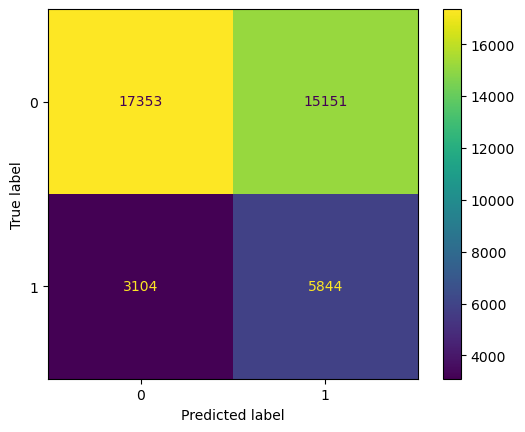

In [4]:
# Train a predictive model using XGBoost Classifier
model_xgb = XGBClassifier(random_state=123)
model_xgb.fit(X_train, y_train)

# Evaluate the model on the test set and calculate recall
y_pred = model_xgb.predict(X_test)

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(model_xgb, X_test, y_test)



### Question 4

##### We are aiming at estimating the total cost the bank would pay without the predictive model

##### The following are penalties the bank incurrs in the case of these complaints :
##### 1. If the complaint is filed the cost incurred is $100 for all complaints
##### 2. If the banks resolution is accepted by the customer the matter is resolved
##### 3. If the banks resolation is rejected by the customer there is an additional cost of $500 the bank has to bear

In [5]:
# Define a function to calculate the cost of dealing with a complaint
def calculate_complaint_cost(complaint_row):
    # Replace this with your logic to calculate the cost
    # Example: if a complaint is costly and you have a cost associated with it
    if complaint_row['Consumer disputed?'] == 'Yes':
        return 600  # Replace 100 with the actual cost
    else:
        return 100  # Replace 50 with the actual cost for other complaints

# Apply the function to each complaint in the test set
test_set = complaints.sample(frac=0.2, random_state=123)  # Assuming a 20% test set split
test_set['Complaint Cost'] = test_set.apply(calculate_complaint_cost, axis=1)

# Calculate the total cost
cost_without_model = test_set['Complaint Cost'].sum()

print(f"Estimated total cost without a model : ${cost_without_model}")

Estimated total cost without a model : $8619200


### Question 5

##### We are making predictions on the basis of the following penalties mentioned above in the case of these complaints. Following this we have another scenario :
##### Using the predictions the bank can understand the probability of whether a complaint resolution will be accepted or rejected by the customer. If a complaint is more probable to be rejected, the bank can further invest an additional $90 for extra due dilligence. This helps them save the huge amount on rejections.

Estimated total cost with a model : $7586750
[[17353 15151]
 [ 3104  5844]]


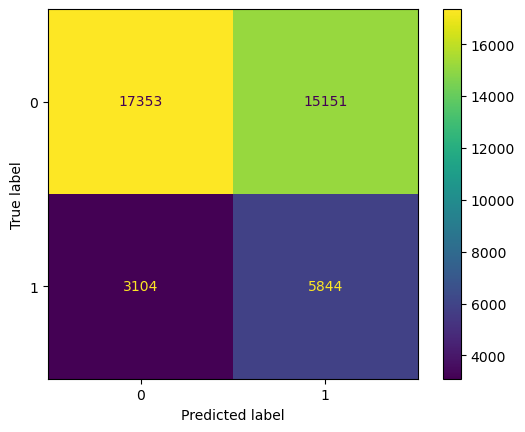

In [6]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate total cost
true_negatives, false_positives, false_negatives, true_positives = cm.ravel()

cost_with_model = (true_negatives*100) + ((true_positives+false_positives)*(100+90)) + (false_negatives*600)

print(f"Estimated total cost with a model : ${cost_with_model}")
print(cm)
# Display the confusion matrix using ConfusionMatrixDisplay
display = ConfusionMatrixDisplay(confusion_matrix=cm)
# Plot the confusion matrix
display.plot()

### Question 6 & 7

##### Now we will try to check which is the best threshold for which the bank has to pay the minimum penalty.
##### Data points with predictions above the threshold are classified as one class, while those below it are classified as the other class in binary classification tasks. 

In [7]:
# Initialize variables to keep track of the best threshold and lowest cost
best_threshold = 0
lowest_cost = float('inf')

# Iterate through different threshold values
for threshold in np.linspace(0, 1, 101):  # Adjust the range and granularity as needed
    # Make predictions on the test set
    y_prob = model_xgb.predict_proba(X_test)
    # We drop the probabilities for class 0, and keep just the second column
    y_prob = y_prob[:,1]
    y_pred = (y_prob >= threshold).astype(int)  # Predict using the threshold

    # Calculate the confusion matrix
    confusion = confusion_matrix(y_test, y_pred)

    # Calculate total cost
    tn, fp, fn, tp = confusion.ravel()
    total_cost = ((tn*100) + ((tp+fp)*(100+90)) + (fn*600))

    # Check if this threshold results in a lower cost
    if total_cost < lowest_cost:
        lowest_cost = total_cost
        best_threshold = threshold

print(f"Best threshold for the lowest total cost: {best_threshold}")
print(f"Lowest total cost: ${lowest_cost}")

Best threshold for the lowest total cost: 0.46
Lowest total cost: $7491540
